In [94]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import os
# import ffmpeg
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pydub import AudioSegment as AS
from pydub import effects
import noisereduce as nr
import tensorflow as tf
import tensorflow_io as tfio
import keras
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import sys
import h5py
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Input,Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from keras.layers import Bidirectional, LSTM, Reshape
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import pickle
import seaborn as sns
import datetime

In [2]:
def get_signal(df):
    librosa_signals = []
    normalized_librosa_signals = []
    trimmed_librosa_signals = []
    pydub_signals = []
    normalized_pydub_signals = []
    trimmed_pydub_signals = []
    for index, row in df.iterrows():
        path  = row['path']
        librosa_signal, sr = librosa.load(path)
        librosa_signals.append(librosa_signal)
        normalized_librosa_signal = librosa.util.normalize(librosa_signal)
        normalized_librosa_signals.append(normalized_librosa_signal)
        trimmed_librosa_signal, index = librosa.effects.trim(normalized_librosa_signal, top_db = 30)
        trimmed_librosa_signals.append(trimmed_librosa_signal)

    df['signal'] = librosa_signals
    df['normalized_signal'] = normalized_librosa_signals
    df['trimmed_signal'] = trimmed_librosa_signals

    
    return df

In [12]:
def get_sample_from_df(df, row_nr = None):
    if not row_nr:
        n_rows = df.shape[0]
        row_nr = np.random.randint(0, n_rows)
    return df.iloc[row_nr]


def do(sample, column):
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(sample[column], sr = 22050)
    plt.title(column)
    plt.show()
    
def do_plot(signal):
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(signal, sr = 22050)
#     plt.title(column)
    plt.show()

In [97]:
CREMA_df = pd.read_pickle('CREMA_df.pkl')
RAVDESS_df = pd.read_pickle('RAVDESS_df.pkl')
SAVEE_df = pd.read_pickle('SAVEE_df.pkl')
TESS_df = pd.read_pickle('TESS_df.pkl')

In [5]:
all_df = pd.concat([TESS_df, SAVEE_df, CREMA_df, RAVDESS_df]).reset_index(drop=True)

<AxesSubplot:xlabel='emotion', ylabel='count'>

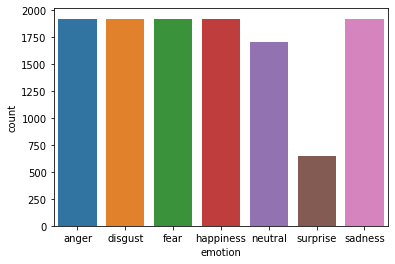

In [100]:
sns.countplot(x='emotion',data=all_df)

In [ ]:
CREMA_df2 = pd.read_pickle('CREMA_df2.pkl')
RAVDESS_df2 = pd.read_pickle('RAVDESS_df2.pkl')
SAVEE_df2 = pd.read_pickle('SAVEE_df2.pkl')
TESS_df2 = pd.read_pickle('TESS_df2.pkl')

In [ ]:
all_df2 = pd.concat([TESS_df2, SAVEE_df2, CREMA_df2, RAVDESS_df2]).reset_index(drop=True)

In [ ]:
sns.countplot(x='sex_emotion',data=all_df)

In [ ]:
CREMA_F_df = pd.read_pickle('CREMA_F_df.pkl')
RAVDESS_F_df = pd.read_pickle('RAVDESS_F_df.pkl')
CREMA_M_df = pd.read_pickle('CREMA_M_df.pkl')
RAVDESS_M_df = pd.read_pickle('RAVDESS_M_df.pkl')

In [ ]:
female_df = pd.concat([TESS_df, CREMA_F_df, RAVDESS_F_df]).reset_index(drop=True)

In [ ]:
sns.countplot(x='emotion',data=female_df)

In [ ]:
male_df = pd.concat([SAVEE_df, CREMA_M_df, RAVDESS_M_df]).reset_index(drop=True)

In [ ]:
sns.countplot(x='emotion',data=male_df)

In [6]:
crema = get_signal(CREMA_df)
rav = get_signal(RAVDESS_df)
sav = get_signal(SAVEE_df)
tess = get_signal(TESS_df)

In [46]:
def add_noise(data):
    noise_amp = 0.05*np.random.uniform()*np.amax(data)
    data = data.astype('float32') + noise_amp * np.random.normal(size=data.shape[0])
    return data


def add_time_stretching_slower(data, rate=0.5):
    data = librosa.effects.time_stretch(data, rate=rate)
    return data


def add_time_stretching_faster(data, rate=2.0):
    data = librosa.effects.time_stretch(data, rate=rate)
    return data


def add_time_shifting(data):
    data = np.roll(data, int(22050/10))
    return data


def add_pitch_shifting(data):
    data = librosa.effects.pitch_shift(y=data, sr=22050, n_steps = -5)

    return data

def pad_signal(data, max_length = 157409):
    data = librosa.util.fix_length(data=data, size=max_length)
    return np.array(data)

def get_log_mel_spec(data):
    mel_spectogram = librosa.feature.melspectrogram(y=data, sr = 22050)
    logspec = librosa.power_to_db(mel_spectogram)
    return logspec

def get_mfcc(data):
    mfcc = librosa.feature.mfcc(y = data, sr=22050, n_mfcc=20)
    return mfcc

def get_deltas(mfcc):
    d1 = librosa.feature.delta(mfcc, order=1)
    d2 = librosa.feature.delta(mfcc, order=2)
    return d1, d2


    

def get_features(data):
    mel_spectogram = librosa.feature.melspectrogram(y=data, sr = 22050)
    features = librosa.power_to_db(mel_spectogram)
#     features = np.expand_dims(logspec, axis=-1)
#     mfcc = librosa.feature.mfcc(y = data, sr=22050, n_mfcc=20)
#     features = np.expand_dims(mfcc, axis=-1)
#     features = librosa.feature.mfcc(y = data, sr=22050, n_mfcc=20)
    #deltas
#     d1 = librosa.feature.delta(mfcc, order=1)
#     d2 = librosa.feature.delta(mfcc, order=2)
#     features = np.concatenate((mfcc, d1, d2), axis=0)
    #rms and zcr
#     rms = librosa.feature.rms(y = data)
#     zcr = librosa.feature.zero_crossing_rate(y = data)
#     features = np.concatenate((mfcc, rms, zcr), axis=0)
    return features

def add_freq_mask(data):
    data = np.array(tfio.audio.freq_mask(data, param=4), dtype=np.float32)
    return df


def add_time_mask(data):
    data = np.array(tfio.audio.time_mask(data, param=4), dtype=np.float32)
    return df

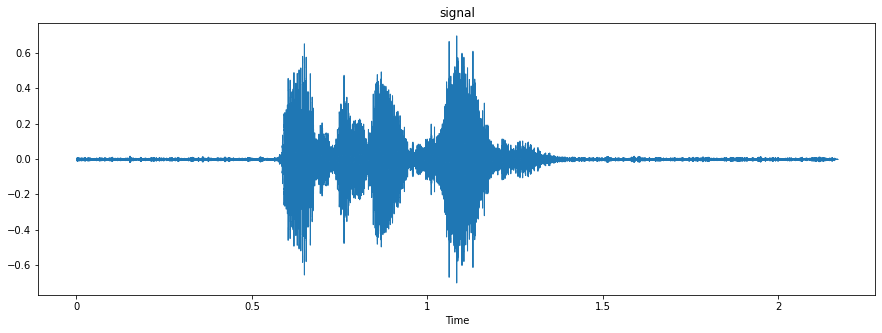

In [71]:
do (get_sample_from_df(crema, row_nr = 2), column = 'signal')

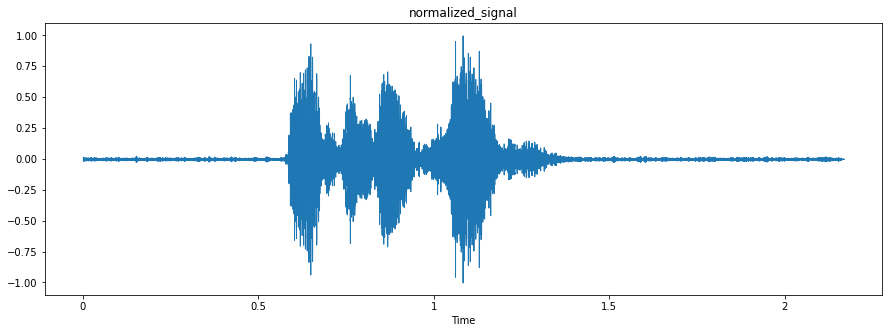

In [72]:
do (get_sample_from_df(crema, row_nr = 2), column = 'normalized_signal')

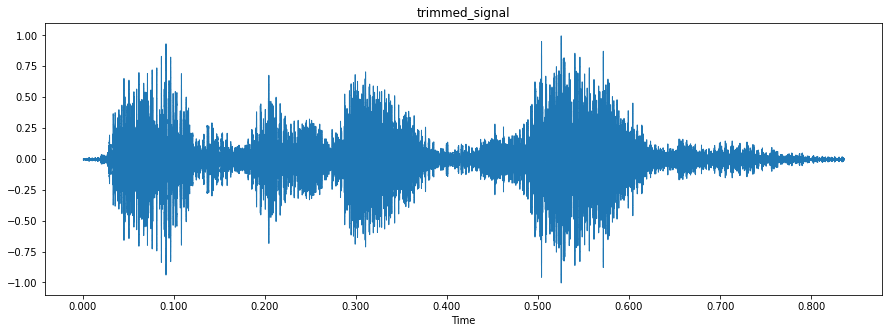

In [73]:
do (get_sample_from_df(crema, row_nr = 2), column = 'trimmed_signal')

In [74]:
signal = np.array(crema['trimmed_signal'][2])

In [75]:
padded = pad_signal(signal)

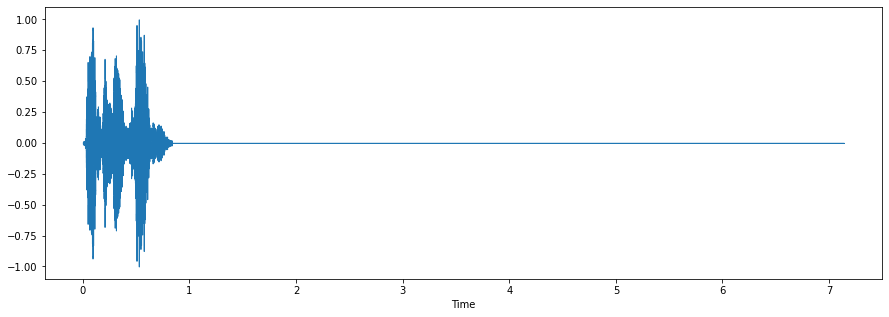

In [76]:
do_plot(padded)

In [77]:
noised = add_noise(signal)

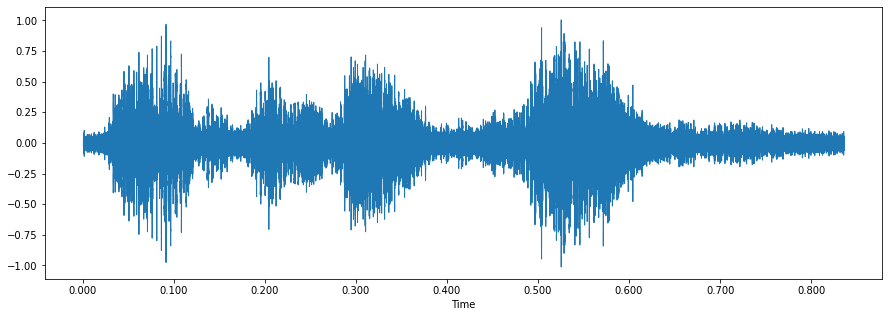

In [78]:
do_plot(noised)

In [81]:
slower = add_time_stretching_slower(signal)

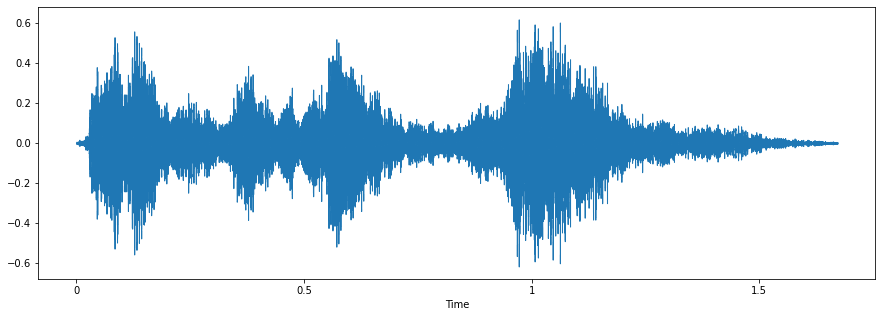

In [82]:
do_plot(slower)

In [83]:
faster = add_time_stretching_faster(signal)

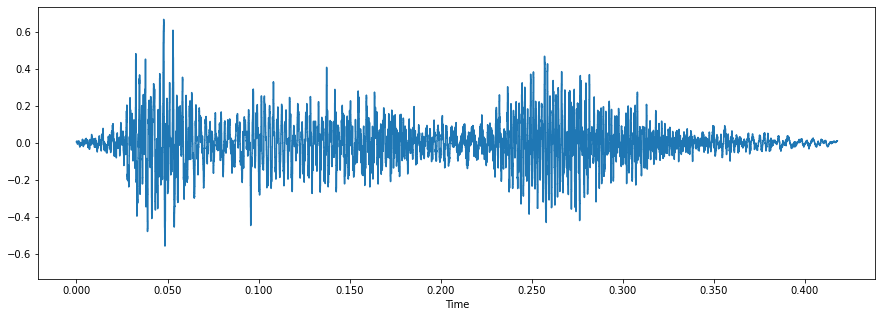

In [84]:
do_plot(faster)

In [89]:
time_shift = add_time_shifting(signal)

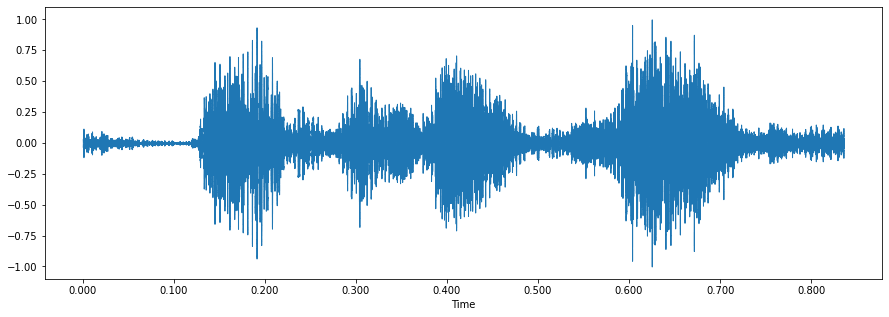

In [90]:
do_plot(time_shift)

In [91]:
pitch_shift = add_pitch_shifting(signal)

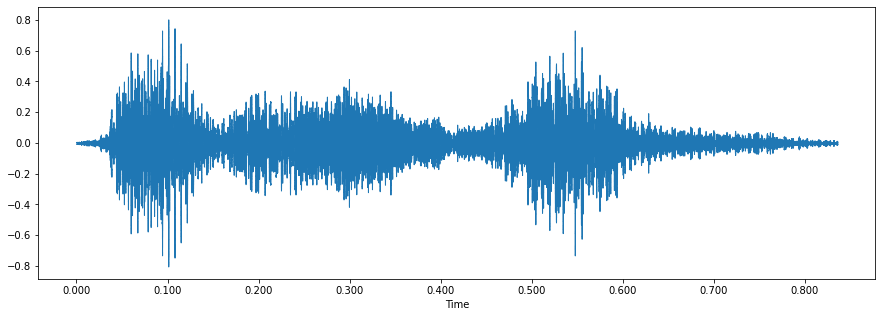

In [92]:
do_plot(pitch_shift)